## imports and Setup

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

## Load Data

In [2]:
senti = pd.read_csv("data/fear_greed_index.csv")
trade = pd.read_csv("data/historical_data.csv")

## Data Exploration (EDA)

In [3]:
senti.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
senti.shape

(2644, 4)

In [5]:
senti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [6]:
senti.isnull().sum()

timestamp         0
value             0
classification    0
date              0
dtype: int64

In [7]:
senti.duplicated().sum()

np.int64(0)

In [8]:
trade.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [9]:
trade.shape

(211224, 16)

In [10]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [11]:
trade.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [12]:
trade.duplicated().sum()

np.int64(0)

## Preprocessing and Feature Engineering

In [13]:
trade["Win"] = trade["Closed PnL"] > 0

In [14]:
def leverage(x):
    if x <= trade["Size USD"].quantile(0.33):
        return "Small leverage"
    elif x <= trade["Size USD"].quantile(0.66):
        return "Medium leverage"
    else:
        return "high leverage"

trade["Leverage"] = trade["Size USD"].apply(leverage)

In [15]:
senti["Date"] = pd.to_datetime(senti["date"]).dt.normalize()
senti2 = senti.drop(["timestamp", "date"], axis=1)

In [16]:
trade["Date"] = pd.to_datetime(trade["Timestamp"], unit="ms").dt.normalize()
trade2 = trade.drop("Timestamp", axis=1)

## Merge Datasets

In [17]:
data = pd.merge(trade2, senti2, how="left", on="Date")

In [18]:
data.isnull().sum()

Account                 0
Coin                    0
Execution Price         0
Size Tokens             0
Size USD                0
Side                    0
Timestamp IST           0
Start Position          0
Direction               0
Closed PnL              0
Transaction Hash        0
Order ID                0
Crossed                 0
Fee                     0
Trade ID                0
Win                     0
Leverage                0
Date                    0
value               26961
classification      26961
dtype: int64

In [19]:
data.duplicated().sum()

np.int64(0)

In [20]:
Mdata = data.dropna()

In [21]:
Mdata

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Win,Leverage,Date,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.000000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,False,high leverage,2024-10-27,74.0,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.000000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,False,Small leverage,2024-10-27,74.0,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.000000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,False,Medium leverage,2024-10-27,74.0,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.000000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,False,Medium leverage,2024-10-27,74.0,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.000000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,False,Small leverage,2024-10-27,74.0,Greed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210763,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,4.13,551.77,BUY,18-04-2025 20:03,-1797.880000,Close Short,-82.883731,0xbbde0f181b617f8d2e2a0421c9a82a02077000c2d6ba...,87333347541,False,0.055176,6.900000e+14,False,Medium leverage,2025-02-19,44.0,Fear
210764,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,7.50,1002.00,BUY,18-04-2025 20:03,-1793.750000,Close Short,-150.515250,0x6bd337120e6f682326d30421c9a82a02077100566072...,87333347541,False,0.100200,6.610000e+13,False,Medium leverage,2025-02-19,44.0,Fear
210765,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,3.93,525.05,BUY,18-04-2025 20:03,-1786.250000,Close Short,-78.869991,0xdbff44ed44a78acf124c0421c9a82a0207720000b450...,87333347541,False,0.052504,1.010000e+15,False,Medium leverage,2025-02-19,44.0,Fear
210766,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,4.34,579.82,BUY,18-04-2025 20:03,-1782.320000,Close Short,-87.098158,0xd8f4fcfddd57c09658a90421c9a82a0207780007b85e...,87333347541,False,0.057982,2.700000e+13,False,Medium leverage,2025-02-19,44.0,Fear


In [22]:
Mdata.classification.value_counts()

classification
Fear             133871
Greed             36289
Neutral            7141
Extreme Greed      6962
Name: count, dtype: int64

## Performance Analysis(PnL, Volatility, Win Rate , T-test)

In [26]:
grouped = Mdata.groupby(["Account", "Date", "classification"])
daily_pnl = grouped["Closed PnL"].agg(np.sum).reset_index(name="pnl")
daily_pnl["pnl"] = daily_pnl["pnl"].round(2).astype(int)
daily_pnl.to_csv("outputs/daily_pnl_per_account.csv",index=False)
daily_pnl

,Account,Date,classification,pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-327505
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1927735
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,20607
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,17098
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,Neutral,-1
...,...,...,...,...
72,0xbaaaf6571ab7d571043ff1e313a9609a10637864,2025-02-19,Fear,940157
73,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2024-10-27,Greed,11671
74,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2025-02-19,Fear,325441
75,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2024-10-27,Greed,684215


In [27]:
daily_pnl.groupby("classification")["pnl"].count()

classification
Extreme Greed     5
Fear             32
Greed            32
Neutral           8
Name: pnl, dtype: int64

In [28]:
Volatility = daily_pnl.groupby("classification")["pnl"].std().reset_index(name="volatility")
Volatility.to_csv("outputs/Volatility",index=False)
Volatility

,classification,volatility
0,Extreme Greed,85325.486538
1,Fear,380423.850659
2,Greed,282694.180281
3,Neutral,57227.560171


In [30]:
win_by_sentiment = Mdata.groupby("classification")["Win"].mean() * 100
win_by_sentiment = win_by_sentiment.round(2).reset_index(name="Win rate %")
win_by_sentiment.to_csv("outputs/winrate_per_by_sentiment.csv",index=False)
win_by_sentiment

,classification,Win rate %
0,Extreme Greed,49.01
1,Fear,41.51
2,Greed,44.65
3,Neutral,31.72


In [31]:
Avg_profit = daily_pnl.groupby("classification")["pnl"].mean().reset_index(name="Avg_pnl")
Avg_profit.to_csv("outputs/Average_pnl_by_sentiment.csv",index=False)
Avg_profit

,classification,Avg_pnl
0,Extreme Greed,35393.00000
1,Fear,209372.21875
2,Greed,99675.18750
3,Neutral,19842.75000


In [32]:
daily_pnl_sum= daily_pnl.groupby("classification")["pnl"].agg(np.sum).reset_index(name="pnl")
daily_pnl_sum

,classification,pnl
0,Extreme Greed,176965
1,Fear,6699911
2,Greed,3189606
3,Neutral,158742


## Performance Plots

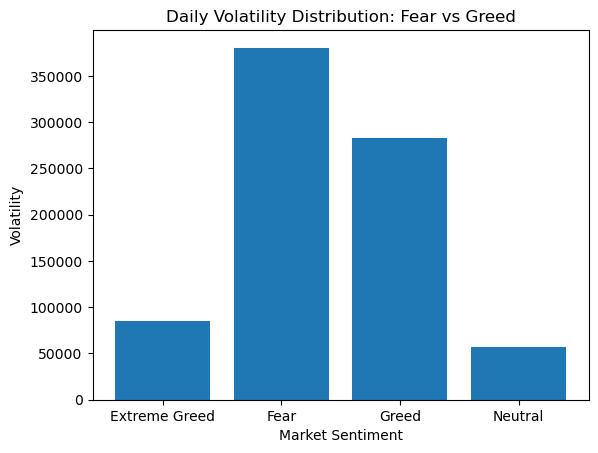

In [33]:
plt.figure()
plt.bar(Volatility["classification"], Volatility["volatility"])
plt.xlabel("Market Sentiment")
plt.ylabel("Volatility")
plt.title("Daily Volatility Distribution: Fear vs Greed")
plt.savefig("outputs/volatility_by_sentiment.png", dpi=150)
plt.show()

##### Drawdown risk is highest during Fear periods and lowest during Neutral days, indicating that negative sentiment leads to greater downside risk.

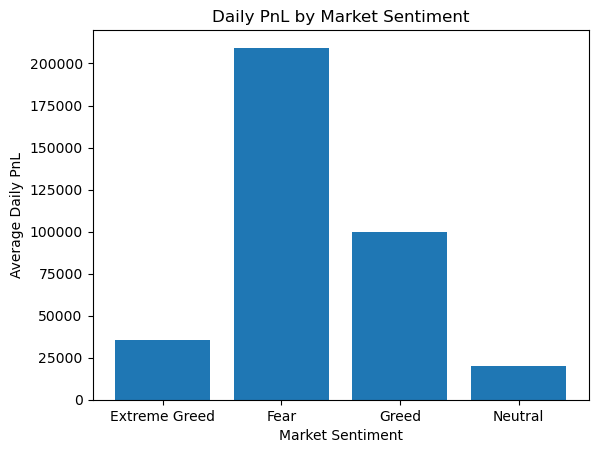

In [34]:
plt.figure()
plt.bar(Avg_profit["classification"], Avg_profit["Avg_pnl"])
plt.xlabel("Market Sentiment")
plt.ylabel("Average Daily PnL")
plt.title("Daily PnL by Market Sentiment")
plt.savefig("outputs/avg_pnl_by_sentiment.png", dpi=150)
plt.show()


##### The daily PnL distribution shows substantial variability across sentiment regimes.
##### Both Fear and Greed periods exhibit significant volatility. Fear periods appear to contain larger positive outliers, 
##### while Greed periods demonstrate both moderate gains and notable drawdowns. 
##### This suggests that performance is sentiment-sensitive, 
##### though statistical comparison is required to confirm significance.

In [35]:
extreme_greed = daily_pnl[daily_pnl['classification'] == 'Extreme Greed']['pnl']
fear = daily_pnl[daily_pnl['classification'] == 'Fear']['pnl']
neutral = daily_pnl[daily_pnl['classification'] == 'Neutral']['pnl']
greed = daily_pnl[daily_pnl['classification'] == 'Greed']['pnl']

f_stat, p_value = stats.f_oneway(extreme_greed, fear, neutral, greed)
print(f_stat)
print(p_value)

1.29110249039811
0.2839282033509467


In [36]:
if p_value < 0.05:
    print(" Significant difference in PnL across sentiment groups")
else:
    print(" No significant difference in PnL across sentiment groups")

 No significant difference in PnL across sentiment groups


##### Greed periods show moderate gains, while Fear periods show notable drawdowns,
##### indicating visible differences in performance across sentiment regimes.
##### However, the ANOVA test indicates that these differences in average daily PnL are not statistically significant (p-value > 0.05).
##### This means that although the charts visually suggest large differences,
##### the high volatility and small sample sizes make it difficult to confirm that sentiment alone drives consistent performance differences.
##### Overall, trading performance appears sentiment-sensitive in distribution,
##### but not statistically robust in mean differences across sentiment groups.
##### Further analysis (e.g., non-parametric tests, larger sample sizes, 
##### or median-based comparisons) would be needed to establish stronger statistical evidence.

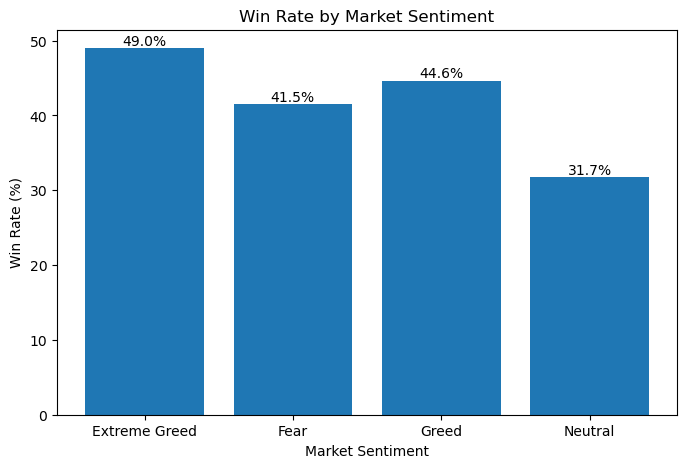

In [37]:
plt.figure(figsize=(8,5))
bars = plt.bar(win_by_sentiment["classification"], win_by_sentiment["Win rate %"])
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate (%)")
plt.title("Win Rate by Market Sentiment")


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             f'{height:.1f}%',
             ha='center',
             va='bottom')
plt.savefig("outputs/win_rate_by_sentiment.png", dpi=150)
plt.show()

##### -Extreme Greed has highest win rate.
##### -Neutral has lowest win rate.
##### -Fear and Greed are moderate.
##### -So yes ,win rate does differ across sentiments.

## Behavior Analysis ( Frequency , Leverage , Long/Short , Position Size )

### Trade Frequency

In [38]:
Trade_frequency = Mdata.groupby("classification").size().reset_index(name="No. Of Trades")

Trade_count = Mdata.groupby("Date").size().reset_index(name="trade_per_day")
Trade_count["trade_per_day"].mean()

np.float64(30710.5)

### Leverage Distribution

In [39]:
counts = Mdata.groupby(["classification","Leverage"]).size().reset_index(name="count")
counts["percent"] = counts.groupby("classification")["count"].transform(lambda x: x / x.sum() * 100)
leverage_percent = counts.pivot(index="classification", columns="Leverage", values="percent")
leverage_percent.to_csv("outputs/Leverage distribution(USD).csv",index=False)
leverage_percent

Leverage,Medium leverage,Small leverage,high leverage
classification,,,
Extreme Greed,25.107728,27.190463,47.701810
Fear,34.623630,31.528113,33.848257
Greed,27.487668,41.034473,31.477858
Neutral,34.392942,36.479485,29.127573


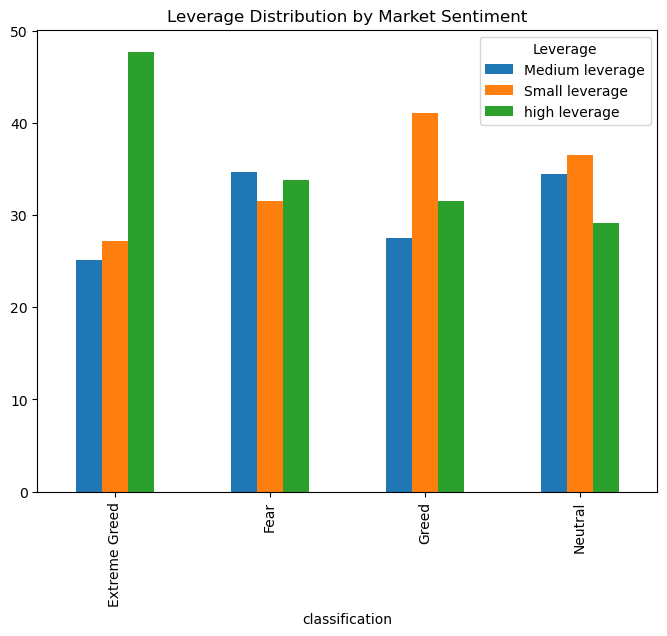

In [40]:
leverage_percent.plot(kind="bar", figsize=(8,6))
plt.title("Leverage Distribution by Market Sentiment")
plt.savefig("outputs/leverage_by_sentiment.png", dpi=150)
plt.show()

##### Leverage usage varies across market sentiment. 
##### Traders use higher leverage during Greed and Extreme Greed, 
##### indicating aggressive risk-taking in optimistic markets.
##### During Fear, leverage shifts toward lower levels, reflecting more cautious behavior.
##### This shows that traders adjust risk exposure based on market sentiment.

### Long/Short Bias

In [41]:
Long_count = Mdata[Mdata["Side"] == "BUY"].shape[0]
Short_count = Mdata[Mdata["Side"] == "SELL"].shape[0]
Long_Short_ratio = round(Long_count / Short_count, 2)

In [42]:
LSB_by_sentiment = Mdata.groupby(["classification", "Side"]).size().unstack(fill_value=0)
LSB_by_sentiment["Long_Short_Ratio"] = LSB_by_sentiment["BUY"] / LSB_by_sentiment["SELL"]
LSB_by_sentiment.to_csv("outputs/LSB by sentiment",index=False)
LSB_by_sentiment.round(2)

Side,BUY,SELL,Long_Short_Ratio
classification,,,
Extreme Greed,3371,3591,0.94
Fear,66081,67790,0.97
Greed,15421,20868,0.74
Neutral,3505,3636,0.96


##### The long/short ratio varies across market sentiment regimes,
##### indicating sentiment-driven directional behavior.
##### Greed periods exhibit the strongest short bias ,
##### suggesting that traders open significantly more short positions,
##### possibly reflecting contrarian positioning or profit-taking in optimistic markets.
##### In contrast, Fear and Neutral periods show ratios close to 1, indicating more balanced long and short activity.
##### Extreme Greed also shows a mild short bias. Overall, 
##### traders adjust their directional exposure in response to market sentiment.

### Position Size

In [43]:
Avg_position_size = Mdata.groupby("classification")["Size USD"].mean().reset_index(name="Avg USD Size")
Avg_position_size.to_csv("outputs/Avg Position size(USD) by sentiment.csv",index=False)
Avg_position_size

,classification,Avg USD Size
0,Extreme Greed,5660.265764
1,Fear,5259.977837
2,Greed,3182.883845
3,Neutral,3058.848110


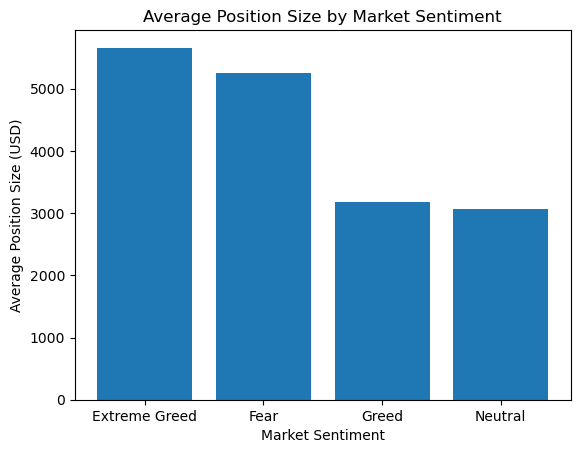

In [44]:
plt.figure()
plt.bar(Avg_position_size["classification"], Avg_position_size["Avg USD Size"])
plt.xlabel("Market Sentiment")
plt.ylabel("Average Position Size (USD)")
plt.title("Average Position Size by Market Sentiment")
plt.savefig("outputs/position_size_by_sentiment.png", dpi=150)
plt.show()

##### The chart shows that average position sizes vary across market sentiment regimes. 
##### Extreme Greed and Fear exhibit the largest average position sizes,
##### indicating higher risk exposure during emotionally charged market conditions.
##### In contrast, Greed and Neutral periods show smaller average position sizes,
##### suggesting more controlled and conservative position sizing.
##### This pattern indicates that traders adjust their capital allocation based on sentiment, 
##### taking larger positions during extreme market emotions and reducing exposure in calmer conditions.

## Trader Segmentation Analysis

### Frequent vs Infrequent Traders

In [45]:
trades_per_account = Mdata.groupby("Account").size().reset_index(name="trade_count")
trades_per_account

,Account,trade_count
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3853
2,0x271b280974205ca63b716753467d5a371de622ab,1146
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13266
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3234
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,617
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,3589
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,332
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,383
9,0x430f09841d65beb3f27765503d0f850b8bce7713,1051


In [46]:
median_trades = trades_per_account["trade_count"].median()
median_trades

3152.5

In [47]:
trades_per_account["frequency_group"] = trades_per_account["trade_count"].apply(lambda x: "Frequent" if x > median_trades else "Infrequent")
trades_per_account.to_csv("outputs/frequency and trade count",index=False)
trades_per_account

,Account,trade_count,frequency_group
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,Frequent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3853,Frequent
2,0x271b280974205ca63b716753467d5a371de622ab,1146,Infrequent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13266,Frequent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3234,Frequent
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,617,Infrequent
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,3589,Frequent
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,332,Infrequent
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,383,Infrequent
9,0x430f09841d65beb3f27765503d0f850b8bce7713,1051,Infrequent


In [48]:
Mdata = pd.merge(Mdata, trades_per_account, how="left", on="Account")
Mdata

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Win,Leverage,Date,value,classification,trade_count,frequency_group
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.000000,...,True,0.345404,8.950000e+14,False,high leverage,2024-10-27,74.0,Greed,372,Infrequent
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.000000,...,True,0.005600,4.430000e+14,False,Small leverage,2024-10-27,74.0,Greed,372,Infrequent
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.000000,...,True,0.050431,6.600000e+14,False,Medium leverage,2024-10-27,74.0,Greed,372,Infrequent
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.000000,...,True,0.050043,1.080000e+15,False,Medium leverage,2024-10-27,74.0,Greed,372,Infrequent
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.000000,...,True,0.003055,1.050000e+15,False,Small leverage,2024-10-27,74.0,Greed,372,Infrequent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184258,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,4.13,551.77,BUY,18-04-2025 20:03,-1797.880000,Close Short,-82.883731,...,False,0.055176,6.900000e+14,False,Medium leverage,2025-02-19,44.0,Fear,1134,Infrequent
184259,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,7.50,1002.00,BUY,18-04-2025 20:03,-1793.750000,Close Short,-150.515250,...,False,0.100200,6.610000e+13,False,Medium leverage,2025-02-19,44.0,Fear,1134,Infrequent
184260,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,3.93,525.05,BUY,18-04-2025 20:03,-1786.250000,Close Short,-78.869991,...,False,0.052504,1.010000e+15,False,Medium leverage,2025-02-19,44.0,Fear,1134,Infrequent
184261,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,4.34,579.82,BUY,18-04-2025 20:03,-1782.320000,Close Short,-87.098158,...,False,0.057982,2.700000e+13,False,Medium leverage,2025-02-19,44.0,Fear,1134,Infrequent


In [49]:
performance_by_frequency = Mdata.groupby(["frequency_group", "classification"])["Closed PnL"].mean().reset_index(name="Avg_PnL")
performance_by_frequency.to_csv("outputs/performance by frequency.csv",index=False)
performance_by_frequency

,frequency_group,classification,Avg_PnL
0,Frequent,Extreme Greed,26.658319
1,Frequent,Fear,44.227117
2,Frequent,Greed,71.259690
3,Frequent,Neutral,4.058759
4,Infrequent,Extreme Greed,-48.382749
5,Infrequent,Fear,91.442580
6,Infrequent,Greed,276.730640
7,Infrequent,Neutral,351.937527


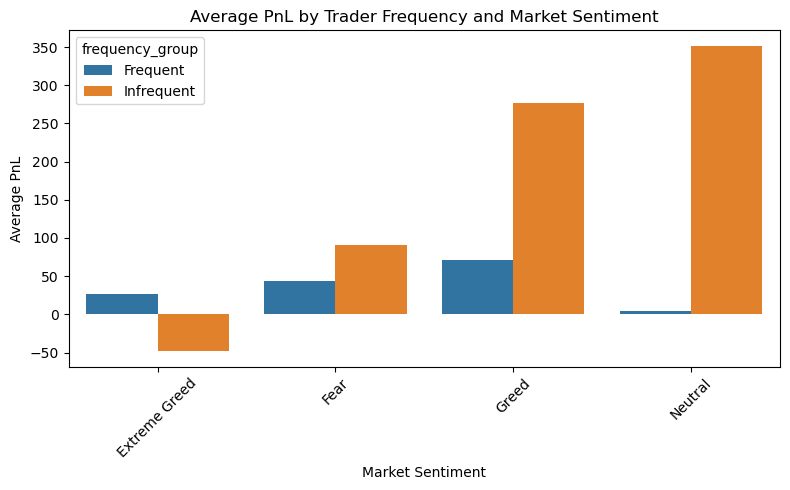

In [50]:
plt.figure(figsize=(8,5))
sns.barplot(data=performance_by_frequency,x="classification",y="Avg_PnL",hue="frequency_group")

plt.title("Average PnL by Trader Frequency and Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/pnl_by_frequency_and_sentiment.png",dpi=150)
plt.show()

##### -Frequent traders show larger changes in average PnL across Fear and Greed, indicating higher sensitivity to market sentiment.
##### -Infrequent traders exhibit more stable but generally lower performance, reflecting lower exposure to market fluctuations.
##### -Higher trading frequency amplifies both potential returns and risk, making frequent traders more vulnerable to sentiment-driven volatility.

## Consistant Winner vs Inconsistent trader

In [51]:
win_rate_by_account = Mdata.groupby("Account")["Win"].mean().reset_index(name="win_rate")
win_rate_by_account.round(2)


,Account,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.36
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.44
2,0x271b280974205ca63b716753467d5a371de622ab,0.43
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.44
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.52
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.29
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,0.33
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,0.48
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,0.23
9,0x430f09841d65beb3f27765503d0f850b8bce7713,0.57


In [52]:
median_win_rate = win_rate_by_account["win_rate"].median()
median_win_rate

0.4070725806451613

In [53]:
win_rate_by_account["Winner_and_Inconsistant_Trader"]= win_rate_by_account["win_rate"].apply(lambda x: "Consistent Winner" if x > median_win_rate else "Inconsistent Trader")
win_rate_by_account.to_csv("outputs/Winner_and_Inconsistant_Trader_winrate_accountwise.csv",index=False)
win_rate_by_account

,Account,win_rate,Winner_and_Inconsistant_Trader
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612,Inconsistent Trader
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.443031,Consistent Winner
2,0x271b280974205ca63b716753467d5a371de622ab,0.430192,Consistent Winner
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438112,Consistent Winner
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519790,Consistent Winner
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.294976,Inconsistent Trader
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,0.327668,Inconsistent Trader
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,0.475904,Consistent Winner
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,0.234987,Inconsistent Trader
9,0x430f09841d65beb3f27765503d0f850b8bce7713,0.569933,Consistent Winner


In [54]:
Mdata = pd.merge(Mdata,win_rate_by_account,on="Account",how="left")
Mdata

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Trade ID,Win,Leverage,Date,value,classification,trade_count,frequency_group,win_rate,Winner_and_Inconsistant_Trader
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.000000,...,8.950000e+14,False,high leverage,2024-10-27,74.0,Greed,372,Infrequent,0.413978,Consistent Winner
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.000000,...,4.430000e+14,False,Small leverage,2024-10-27,74.0,Greed,372,Infrequent,0.413978,Consistent Winner
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.000000,...,6.600000e+14,False,Medium leverage,2024-10-27,74.0,Greed,372,Infrequent,0.413978,Consistent Winner
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.000000,...,1.080000e+15,False,Medium leverage,2024-10-27,74.0,Greed,372,Infrequent,0.413978,Consistent Winner
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.000000,...,1.050000e+15,False,Small leverage,2024-10-27,74.0,Greed,372,Infrequent,0.413978,Consistent Winner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184258,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,4.13,551.77,BUY,18-04-2025 20:03,-1797.880000,Close Short,-82.883731,...,6.900000e+14,False,Medium leverage,2025-02-19,44.0,Fear,1134,Infrequent,0.453263,Consistent Winner
184259,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,7.50,1002.00,BUY,18-04-2025 20:03,-1793.750000,Close Short,-150.515250,...,6.610000e+13,False,Medium leverage,2025-02-19,44.0,Fear,1134,Infrequent,0.453263,Consistent Winner
184260,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,3.93,525.05,BUY,18-04-2025 20:03,-1786.250000,Close Short,-78.869991,...,1.010000e+15,False,Medium leverage,2025-02-19,44.0,Fear,1134,Infrequent,0.453263,Consistent Winner
184261,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,SOL,133.6000,4.34,579.82,BUY,18-04-2025 20:03,-1782.320000,Close Short,-87.098158,...,2.700000e+13,False,Medium leverage,2025-02-19,44.0,Fear,1134,Infrequent,0.453263,Consistent Winner


In [55]:
consistency_counts = win_rate_by_account["Winner_and_Inconsistant_Trader"].value_counts()
consistency_counts.reset_index(name="Total Traders")

,Winner_and_Inconsistant_Trader,Total Traders
0,Inconsistent Trader,16
1,Consistent Winner,16


In [58]:
consistency_avg_win = Mdata.groupby("Winner_and_Inconsistant_Trader")["win_rate"].agg(np.mean)*100
consistency_avg_win=consistency_avg_win.reset_index(name="Avg_win_rate")
consistency_avg_win.to_csv("outputs/Winner_and_Inconsistant_Trader_Winrate_per.csv",index=False)
consistency_avg_win

,Winner_and_Inconsistant_Trader,Avg_win_rate
0,Consistent Winner,48.272307
1,Inconsistent Trader,34.159729


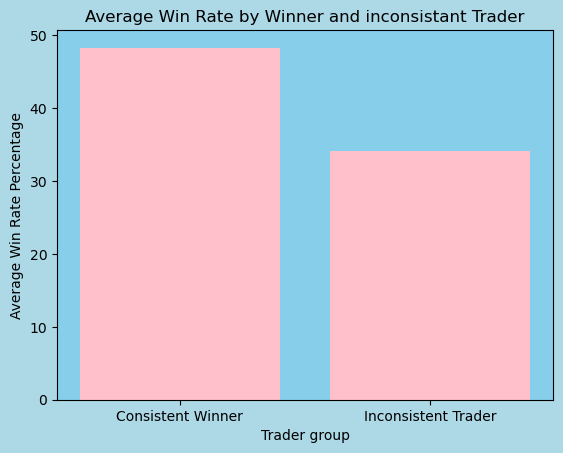

In [59]:

plt.figure(facecolor="lightblue")
plt.bar(consistency_avg_win["Winner_and_Inconsistant_Trader"], consistency_avg_win["Avg_win_rate"],color="pink")
plt.xlabel("Trader group")
plt.ylabel("Average Win Rate Percentage")
plt.title("Average Win Rate by Winner and inconsistant Trader")
plt.gca().set_facecolor("skyblue")
plt.savefig("outputs/winrate_by_consistency.png", dpi=150)
plt.show()

##### -This shows that traders who are more consistent in their strategy tend to win more often.
##### -The clear gap between the two bars suggests that consistency in trading behavior is linked to better performance.
##### -In simple words: being disciplined and consistent helps traders make more winning trades.

## Actionable Output

##### 1) Fear Regime – Risk Reduction (Frequent Traders)
##### Trigger: classification == "Fear" (from daily_pnl['classification'])
##### Action: Reduce leverage to Small/Medium (Leverage), cut position size (Size USD) by 30–50%, tighten stops.
##### Basis: Higher volatility in Fear (Volatility by classification), higher drawdowns; frequent traders more sentiment-sensitive (performance_by_frequency).
##### 2) Extreme Greed – Selective Scaling (Consistent Winners)
##### Trigger: classification == "Extreme Greed"
##### Action: Allow +20–25% position size for Consistent Winner only (Winner_and_Inconsistant_Trader == "Consistent Winner"); keep conservative limits for others.
##### Basis: Highest win rate in Extreme Greed (win_by_sentiment), leverage already higher in Greed/Extreme Greed (leverage_percent), consistency linked to higher win rate (consistency_avg_win).